# Cancelaciones OTP
¿Cómo varı́a la cantidad de vuelos cancelados por mes a través de los años? ¿Está
relacionada con la magnitud de los retrasos y el OTP? ¿Se puede predecir el delay
solamente con las cancelaciones?

¿Se pueden utilizar las cancelaciones como un indicador de performance?

## Build

In [2]:
!cd .. && git submodule init
!cd .. && git submodule update
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python3)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 9.1.0
-- The CXX compiler identification is GNU 9.1.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /home/nicolas/dev/tp3/tp3/bin/python3 (found version "3.7.4") 
-- Found PythonLibs: /usr/lib/libpython3.7m.so
-- pybind11 v2.4.dev4
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/nicolas/dev/tp3
-- Configuring done
-- Generating done
-- Build files have bee

## Imports

In [8]:
import predict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
def otp(dataframe, groups):
    total = dataframe.groupby(groups).size()
    delayed = dataframe[dataframe['ArrDelay']>15].groupby(groups).size()
    return delayed/total

In [3]:
def cancels(dataframe, groups):
    return dataframe[dataframe['Cancelled'] != 0].groupby(groups).size()

    

In [4]:
def nrmse(sample, predicted):
    sqErrors = (sample-predicted)*(sample-predicted)
    ymax = max(sample)
    ymin = min(sample)
    n = len(sample)
    return np.sqrt(1/n*(sum(sqErrors))) / (ymax - ymin)


## Experimentacion

Primero nos quedamos con las columnas que aporten datos sobre cancelaciones. 

In [10]:
files=[
    "1994.csv",
    "1995.csv",
    "1996.csv",
    "1997.csv",
    "1998.csv",
    "1999.csv",
    "2000.csv",
    "2001.csv",
    "2002.csv",
    "2003.csv",
    "2004.csv",
    "2005.csv",
    "2006.csv",
    "2007.csv",
    "2008.csv" 
]
root="../data/"
for f in files:
    path = root + f
    new = path + ".trimmed"
    !cut -f  1,2,15,22 -d , $path > $new

### Cancelaciones mensuales
¿Cómo varı́a la cantidad de vuelos cancelados por mes a través de los años?

In [5]:
cans = pd.Series([])
otps = pd.Series([])
files=[
    "1994.csv.trimmed",
    "1995.csv.trimmed",
    "1996.csv.trimmed",
    "1997.csv.trimmed",
    "1998.csv.trimmed",
    "1999.csv.trimmed",
    "2000.csv.trimmed",
    "2001.csv.trimmed",
    "2002.csv.trimmed",
    "2003.csv.trimmed",
    "2004.csv.trimmed",
    "2005.csv.trimmed",
    "2006.csv.trimmed",
    "2007.csv.trimmed",
    "2008.csv.trimmed" 
]
root="../data/"
for file in files:
    frame = pd.read_csv(root+file)
    monthly_cancels = cancels(frame,['Year','Month'])
    monthly_otps = otp(frame,['Year','Month'])
    cans = pd.concat([cans, monthly_cancels])
    otps = pd.concat([otps, monthly_otps])

    


Saving results to a file...

In [9]:
cans.to_csv("../data/cancellations_per_month.csv", header=False)
otps.to_csv("../data/otps_per_month.csv", header=False)

Quick overview:

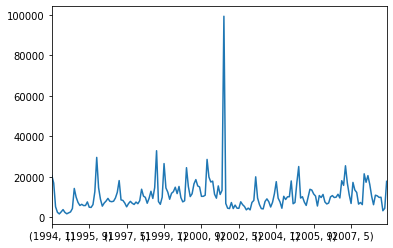

In [10]:
cans.plot()

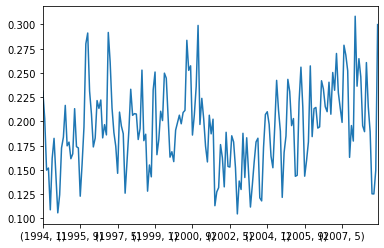

In [11]:
otps.plot()

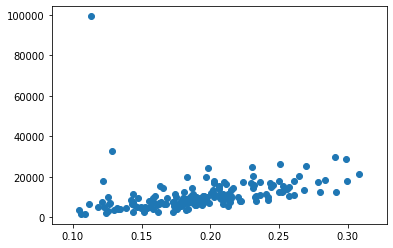

In [12]:
plt.scatter(otps, cans)

### Tratamos de predecir las cancelaciones a traves del tiempo

In [12]:

y = cans.to_numpy()
x = np.array(range(0, y.size))

def cuadratica(x):
    return np.array([x*x,x,1])

def cubica(x):
    return np.array([x*x*x,x*x,x,1])
def grado_cuatro(x):
    return np.array([x*x*x*x, x*x*x, x*x, x, 1])

def trig(x):
    return np.array([math.sin(x), math.cos(x), math.tan(x), x*x, 1])

def trig2(x):
    return np.array([math.sin(x), math.cos(x), x, 1])

def trig3(x):
    return np.array([math.sin(x), x, 1])


    
# Registramos funciones: (funcion, cantidad_de_coeficientes)
funcs = [(cuadratica, 3),(cubica,4),(grado_cuatro, 5),(trig, 5),(trig2,4),(trig3, 3)]

for f, g in funcs:
    cml = predict.CML(f,g)
    cml.fit(x,y)
    predicted = np.array([cml.predict(e) for e in x])
    print("For function: ",f," the error was: ", nrmse(y, predicted))


For function:  <function cuadratica at 0x7f68bc6fe0e0>  the error was:  440.1691365613533
For function:  <function cubica at 0x7f68bc6fe050>  the error was:  107442.41329355098
For function:  <function grado_cuatro at 0x7f68ed1bc9e0>  the error was:  7600288.36506362
For function:  <function trig at 0x7f68ed1bccb0>  the error was:  2092.418699998404
For function:  <function trig2 at 0x7f68bc7737a0>  the error was:  12.297199596605632
For function:  <function trig3 at 0x7f68bc773170>  the error was:  136.78620150687343


La cuadratica es la mas favorable de las polinomicas y vemos que el error cuadratico aumenta con el grado.  
$a*sen(x) + b*cos(x) + c*x + d$ promete mas.  
Falta experimentar que pasa si sacamos el mes outlier de las torres gemelas.  